In [160]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import os

In [ ]:
def classify_bubbles(image_path):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Error: Could not open or find the image at {image_path}")
        return -1

   # Find contours
    contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bubble_areas = []
    # Iterate through each contour and calculate its area
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        bubble_areas.append(area)
        # print(f"Contour {i+1} (Bubble) Area: {area:.2f} pixels")

    bubble_areas.sort(reverse=True)
    bigger_bubbles_area = np.sum(bubble_areas[0:10])
    smaller_bubbles_area = np.sum(bubble_areas[10:])
    if bigger_bubbles_area > smaller_bubbles_area:
        return 1
    return -1

def classify_masks(base_path):
    labels = []
    for filename in os.listdir(base_path):
        label = classify_bubbles(base_path + '\\' + filename)
        labels.append(label)
    return labels

(np.float64(-0.5), np.float64(199.5), np.float64(149.5), np.float64(-0.5))

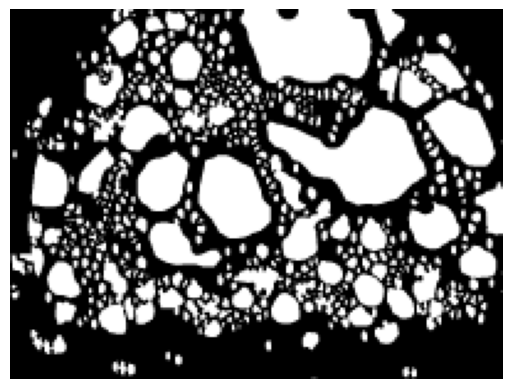

In [183]:

import pywt

def apply_wavelet(image_data):
    n = 2
    w = 'db1'
    coeffs = pywt.wavedec2(image_data,wavelet=w,level=n)
    approximation_coefficients = coeffs[0]
    return approximation_coefficients

def matrix_transform(folder):
    frame_files = sorted([f for f in os.listdir(folder) if f.endswith('.png')])
    frames_as_columns = []

    for f in frame_files:
        img_path = os.path.join(folder, f)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_wavelet = apply_wavelet(img)
        vec = img_wavelet.flatten()
        frames_as_columns.append(vec)

    data = np.array(frames_as_columns, dtype=int).T
    return data

img_path= r'.\masks\F1_1_4_1\frame-000.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

img_wavelet = apply_wavelet(img)
plt.imshow(img_wavelet, cmap='gray')
plt.axis('off')



In [ ]:
folder = r'.\masks\F1_1_4_1'

labels = np.array(classify_masks(folder))
X = matrix_transform(folder)

# number of images classified as 1 and number of images classified as -1
n_pos, n_neg = 116, 246

# Find indices for each bin
indices_pos = np.where(labels == 1)[0]
indices_neg = np.where(labels == -1)[0]

# Sort training_data accordingly (select columns that match the labels)
X_pos = X[:, indices_pos]  # shape: (480000, num of 1s)
X_neg = X[:, indices_neg]  # shape: (480000, num of -1s)

labels_pos = labels[indices_pos]  # should be all 1s
labels_neg = labels[indices_neg]  # should be all -1s
labels = np.concatenate((labels_pos, labels_neg), axis=0)
X = np.concatenate((X_pos, X_neg), axis=1)

In [164]:
# Define randomized SVD function
def rSVD(X,r,q,p):
    # Step 1: Sample column space of X with P matrix
    ny = X.shape[1]
    P = np.random.randn(ny,r+p)
    Z = X @ P
    for k in range(q):
        Z = X @ (X.T @ Z)

    Q, R = np.linalg.qr(Z,mode='reduced')

    # Step 2: Compute SVD on projected Y = Q.T @ X
    Y = Q.T @ X
    UY, S, VT = np.linalg.svd(Y,full_matrices=0)
    U = Q @ UY

    return U, S, VT

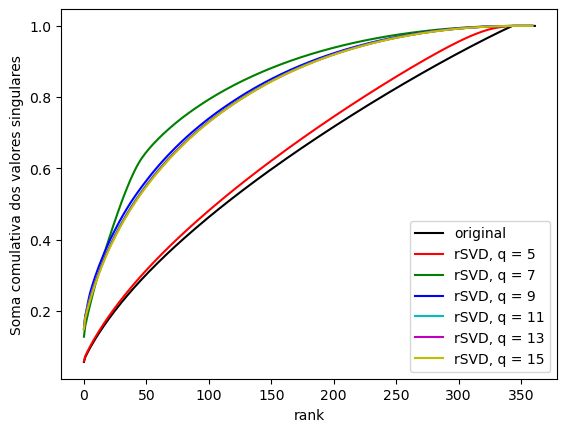

In [168]:
avgdata = np.mean(X, axis=1).astype(np.uint8)

X_svd = X
X_pca = X  - avgdata[:, np.newaxis]
U, S, VT = np.linalg.svd(X_svd, full_matrices=False)
plt.plot(np.cumsum(S)/np.sum(S), 'k', label='original')

colors = ['r','g', 'b', 'c', 'm', 'y']
qs = [5,7,9,11,13,15]
for q, c in zip(qs, colors):
    r = 360 # Target rank
    p = 0   # Oversampling parameter
    # q = 7   # Power iterations
    
    rU, rS, rVT = rSVD(X,r,q,p)
    plt.plot(np.cumsum(rS)/np.sum(rS), c, label=f'rSVD, q = {q}')
plt.ylabel('Soma comulativa dos valores singulares')
plt.xlabel('rank')
plt.legend()
# plt.semilogy(S[:-20], 'k')
# plt.semilogy(rS[:-20], 'r')
U, S, VT = rU, rS, rVT


In [10]:
marker_colors = []
for l in labels:
    if l == 1:
        marker_colors.append('b')
    else:
        marker_colors.append('r')

w:\Miniconda\envs\ml_class\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


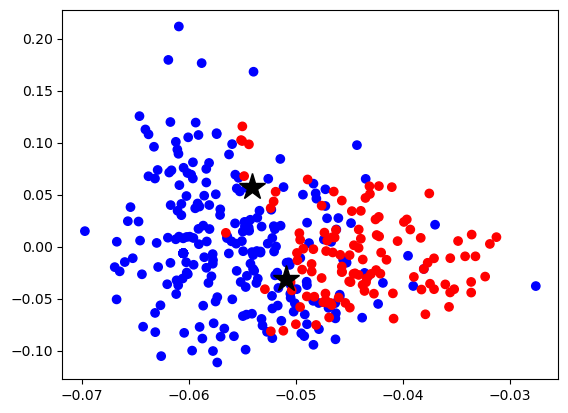

In [143]:
# KMEANS
pc_choice = (0, 3)
from sklearn.cluster import KMeans
v = VT.T
big_small = v[:,pc_choice]

kmeans = KMeans(n_clusters=2, random_state=0).fit(big_small)
c = kmeans.cluster_centers_
ind = kmeans.labels_
plt.scatter(VT[pc_choice[0], :], VT[pc_choice[1], :], c=marker_colors)

# kmeans result
plt.plot(c[0,0],c[0,1],'k*',ms=20)
plt.plot(c[1,0],c[1,1],'k*',ms=20)

plt.show()

In [ ]:
features = (0, 3)
xtrain = np.concatenate((v[:185,features],v[246:333,features]))
xtest = np.concatenate((v[185:246,features],v[333:362,features]))
labels_train = np.concatenate((labels[:185],labels[246:333]))
labels_test = np.concatenate((labels[185:246],labels[333:362]))

Cross validation for best model: 0.223941798941799


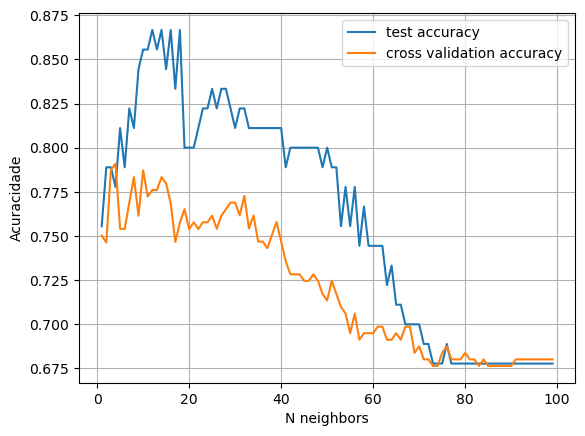

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
right_percentage_list = []
cross_validation_list = []
best_model_percentage = 0.0
best_knn_model = None
n_neighbors_list = range(1, 100)
for n_neighbors in n_neighbors_list:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(xtrain, labels_train)
    y_pred = knn_model.predict(xtest)
    pred = abs(labels_test - y_pred)
    right_percentage = 1.0 - np.count_nonzero(pred)/len(pred)
    right_percentage_list.append(right_percentage)
    cv_knn = cross_val_score(knn_model, xtrain, labels_train, cv=10) #cross-validate the model
    cross_validation_list.append(np.mean(cv_knn))
    if right_percentage > best_model_percentage:
        best_model_percentage = right_percentage
        best_knn_model = knn_model
    # print(f'n_neighbors={n_neighbors}, right_percentage = {right_percentage}')
plt.plot(n_neighbors_list, right_percentage_list, label='test accuracy')
plt.plot(n_neighbors_list, cross_validation_list, label='cross validation accuracy')
plt.grid()
plt.xlabel('N neighbors')
plt.ylabel('Accuracy')
plt.legend()

# Cross validation
cv_knn = np.mean(cross_val_score(best_knn_model, xtrain, labels_train, cv=10)) #cross-validate the model
classLoss = 1-np.mean(cv_knn) # average error over all cross-validation iterations
print("Cross validation for best model:", classLoss)

In [ ]:
CMdl = cross_val_score(Mdl, xtrain, labels_train, cv=10) #cross-validate the model
classLoss = 1-np.mean(CMdl) # average error over all cross-validation iterations

Text(0, 0.5, 'Right Percentage')

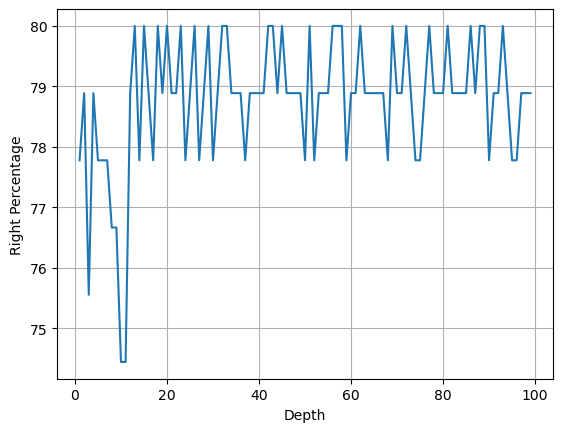

In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

right_percentage_list = []
depth_list = range(1, 100)
for depth in depth_list:
    base_estimator = DecisionTreeClassifier(max_depth=depth) # Árvore de decisão fraca (stump)
    ada_boost_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=100) # Mudar o n_estimator não mudou os resultados, só o max_depth

    ada_boost_model.fit(xtrain, labels_train)
    y_pred_ada = ada_boost_model.predict(xtest)
    pred = abs(labels_test - y_pred_ada)
    right_percentage = 1.0 - np.count_nonzero(pred)/len(pred)
    right_percentage_list.append(100*right_percentage)
    # print(f'max_depth={depth}, right_percentage = {right_percentage}')

plt.plot(depth_list, right_percentage_list)
plt.grid()
plt.xlabel('Depth')
plt.ylabel('Right Percentage')


In [ ]:
import tensorflow as tf
import itertools

# Normalizing data to -1.0 to 1.0 interval to follow tf tutorial
tf_xtrain = np.concatenate((X_svd[:, :184],X_svd[:, 246:333]), axis=1) / 1024
tf_xtest = np.concatenate((X_svd[:, 184:246],X_svd[:, 333:362]), axis=1) / 1024
labels_train = np.concatenate((labels[:184],labels[246:333]))
labels_test = np.concatenate((labels[184:246],labels[333:362]))
tf_labels_train = np.array([0 if label == -1 else 1 for label in labels_train])
tf_labels_test = np.array([0 if label == -1 else 1 for label in labels_test])
print(tf_labels_train)
# tf_labels_test = np.concatenate((labels[184:246],labels[333:362]))
# print(tf_xtrain.T.shape)
# print(tf_labels_train.shape)

In [ ]:
# Apply simple NN
n_neurons = [8, 16, 32, 64, 128]
activation_functions = ['elu', 'relu', 'linear']
models = {}
models_history = {}
for (n_neuron, act_function) in itertools.product(n_neurons, activation_functions):
    print(n_neuron, act_function)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(n_neuron, activation=act_function),
        tf.keras.layers.Dense(2)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(tf_xtrain.T, tf_labels_train, epochs=10, verbose=0, validation_split=0.2)
    models[act_function+'-'+str(n_neuron)] = model
    models_history[act_function+'-'+str(n_neuron)] = model

8 elu
8 relu
8 linear
16 elu
16 relu
16 linear
32 elu
32 relu
32 linear
64 elu
64 relu
64 linear
128 elu
128 relu
128 linear


In [190]:
my_model = models['elu-64']
print(models_history['elu-64'].history['accuracy'][-1])
print(tf_xtest.shape)
opa_y = my_model.predict(tf_xtrain.T)
print(*opa_y)

0.8518518805503845
(30000, 91)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.53323424  1.3491664 ] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5332342  1.3491664] [-0.5

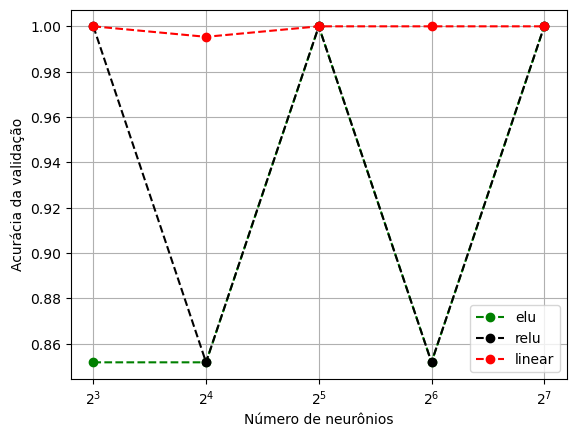

In [196]:
elu_accuracy_list = []
relu_accuracy_list = []
linear_accuracy_list = []
hist_elu_accuracy_list = []
hist_relu_accuracy_list = []
hist_linear_accuracy_list = []
for model_key, model in models.items():
    test_loss, test_acc = model.evaluate(tf_xtest.T,  tf_labels_test, verbose=0)
    if model_key.startswith('elu'):
        elu_accuracy_list.append(test_acc)
        hist_elu_accuracy_list.append(models_history[model_key].history['accuracy'][-1])
    elif model_key.startswith('relu'):
        relu_accuracy_list.append(test_acc)
        hist_relu_accuracy_list.append(models_history[model_key].history['accuracy'][-1])
    elif model_key.startswith('linear'):
        linear_accuracy_list.append(test_acc)
        hist_linear_accuracy_list.append(models_history[model_key].history['accuracy'][-1])

# plt.semilogx(n_neurons, elu_accuracy_list, 'go-', base=2, label='elu test')
# plt.semilogx(n_neurons, relu_accuracy_list, 'ko-', base=2, label='relu test')
# plt.semilogx(n_neurons, linear_accuracy_list, 'ro-', base=2, label='linear test')
plt.semilogx(n_neurons, hist_elu_accuracy_list, 'go--', base=2, label='elu')
plt.semilogx(n_neurons, hist_relu_accuracy_list, 'ko--', base=2, label='relu')
plt.semilogx(n_neurons, hist_linear_accuracy_list, 'ro--', base=2, label='linear')
plt.xticks(n_neurons)
plt.xlabel('Número de neurônios')
plt.ylabel('Acurácia da validação')
plt.grid()
# plt.legend(ncols=2, loc='center right')
plt.legend()

In [ ]:
# CNN application

# Reshape
input_shape_width, input_shape_height = (200, 150)
cnn_xtrain = []
for frame in np.transpose(tf_xtrain, axes=[1,0]):
    # print(frame.shape)
    cnn_xtrain.append(np.reshape(frame, (input_shape_width, input_shape_height)))
cnn_xtrain=np.array(cnn_xtrain)

cnn_xtest = []
for frame in np.transpose(tf_xtest, axes=[1,0]):
    cnn_xtest.append(np.reshape(frame, (input_shape_width, input_shape_height)))
cnn_xtest=np.array(cnn_xtest)
    
# print(input_shape)
n_filters = [4, 8, 16, 32, 64]
models = {}
histories = {}
last_accuracies = {}
best_accuracy = 0.0
best_model = None

for n_filter in n_filters:
    print(n_filter)
    model_cnn = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu', input_shape=(input_shape_width, input_shape_height, 1)),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='softmax'),
    ])

    model_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

    history_dnn = model_cnn.fit(cnn_xtrain, tf_labels_train, epochs=50, verbose=0,validation_split=0.1)
    last_accuracy = history_dnn.history['val_accuracy'][-1]
    histories[n_filter] = history_dnn
    models[n_filter] = model_cnn
    last_accuracies[n_filter] = last_accuracy
    if last_accuracy > best_accuracy:
        best_accuracy = last_accuracy
        best_model = model_cnn
    




4


w:\Miniconda\envs\ml_class\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
w:\Miniconda\envs\ml_class\Lib\site-packages\keras\src\backend\tensorflow\nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8
16
32
64


In [ ]:
print("best accuracy = ", best_accuracy)
print("last accuracy = ", last_accuracies)
for hist_idx, hist in histories.items():
    print(hist.history['val_accuracy'][-1])


best accuracy =  0.5714285969734192
last accuracy =  {4: 0.5357142686843872, 8: 0.5357142686843872, 16: 0.5714285969734192, 32: 0.3571428656578064, 64: 0.3214285671710968}
0.5357142686843872
0.5357142686843872
0.5714285969734192
0.3571428656578064
0.3214285671710968


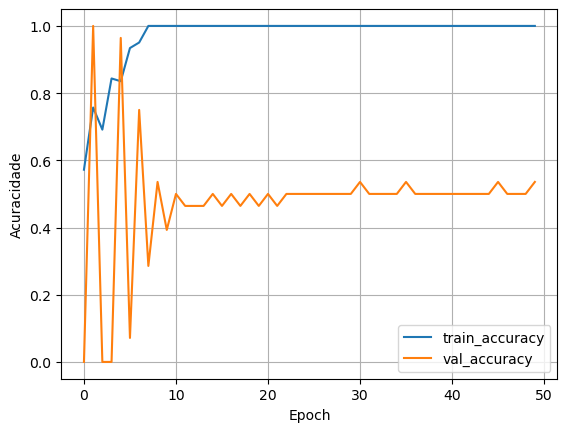

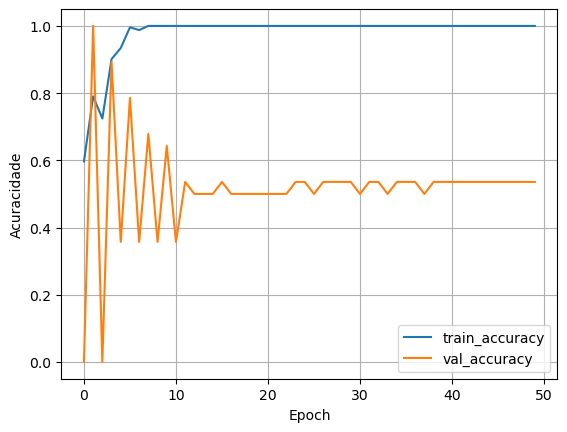

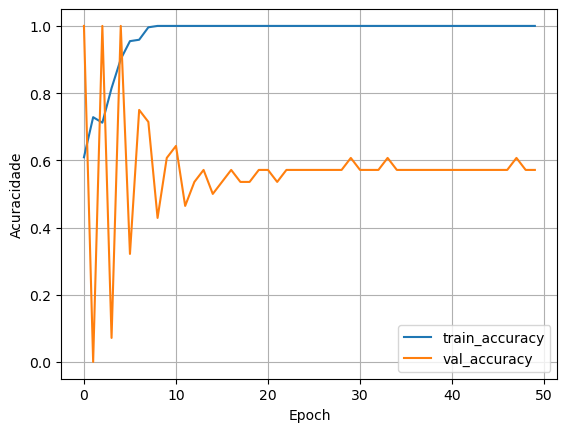

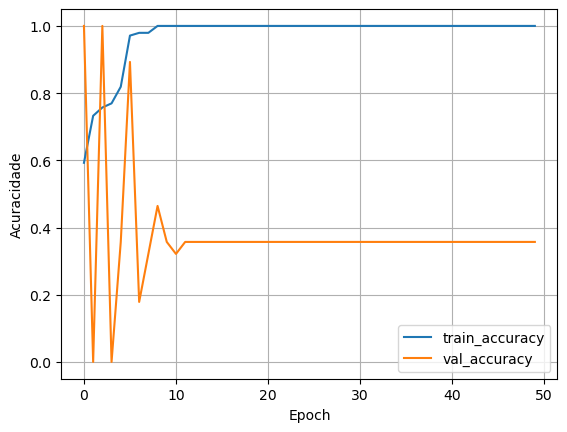

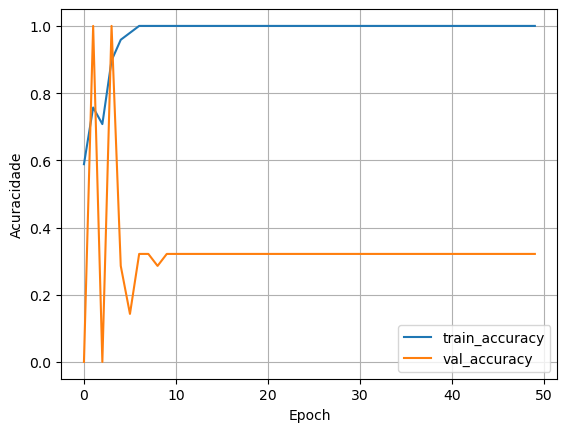

In [218]:
# def plot_loss(history):
#   plt.plot(history.history['loss'], label='train_loss')
#   plt.plot(history.history['val_loss'], label='val_loss')
#   # plt.ylim([0, 100])
#   plt.xlabel('Epoch')
#   plt.ylabel('Error')
#   plt.legend()
#   plt.grid(True)

def plot_accuracy(history):
  plt.figure()
  plt.plot(history.history['accuracy'], label='train_accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  # plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Acuracidade')
  plt.legend()
  plt.grid(True)
  plt.show()

for hist in histories.values():
  plot_accuracy(hist)

In [216]:
print(cnn_xtest.shape)
for model in models.values():
    test_loss, test_acc = model.evaluate(cnn_xtest,  tf_labels_test, verbose=1)
    print(test_acc, test_loss)

cnn_ytest = np.round(model_cnn.predict(cnn_xtest))
# cnn_ytest = model_cnn.predict(cnn_xtest)
print(*cnn_ytest)

(91, 200, 150)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8713 - loss: 0.3611
0.7582417726516724 0.6465457081794739
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8752 - loss: 0.4141
0.7582417726516724 0.7825382947921753
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8619 - loss: 0.3535
0.7472527623176575 0.6503487229347229
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8697 - loss: 0.4251
0.7472527623176575 0.8221598863601685
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8697 - loss: 0.5034
0.7472527623176575 0.9816187620162964
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1.] [0. 1

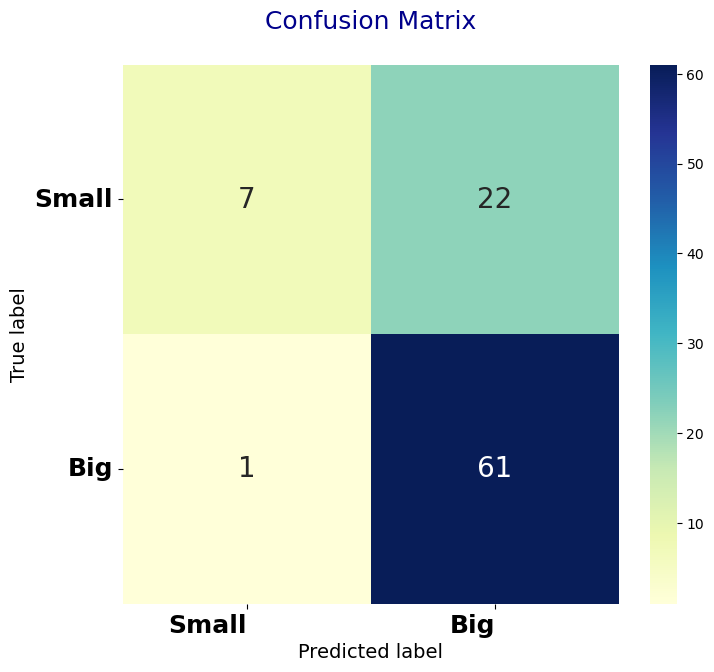

In [215]:
# Confusion matrix
import pandas as pd
import seaborn as sns 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix

# matrix = tf.math.confusion_matrix(tf_labels_test, cnn_ytest[:, 1])

matrix = pd.DataFrame((metrics.confusion_matrix(tf_labels_test, cnn_ytest[:, 1])), 
                      ('Small', 'Big'), 
                      ('Small', 'Big'))

plt.figure(figsize = (8,7),facecolor='white')
heatmap = sns.heatmap(matrix, annot = True, annot_kws = {'size': 20}, fmt = 'd', cmap = 'YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')

plt.title('Confusion Matrix\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()